# Importing Libraries

In [2]:
import tensorflow as tf
import tensorflow.keras

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, Dropout, BatchNormalization, MaxPooling2D, Conv2DTranspose, LeakyReLU, Reshape
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import glob
import imageio
import PIL
import time
from IPython import display

# Loading and Preprocessing the Data

In [4]:
#load the data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
#reshape the images and Normalize
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 100

In [7]:
#shuffle and batch the images
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

# Building the Generator Model

In [9]:
#building a Generator model
def generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(Conv2DTranspose(128, (5, 5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


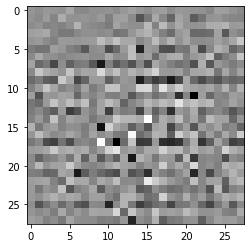

In [10]:
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Building the Discriminator Model

In [11]:
#Discriminator model
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [12]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00216195]], shape=(1, 1), dtype=float32)


* Defining loss functions and optimizers for both models.

In [13]:
from tensorflow.keras.losses import BinaryCrossentropy
cross_entropy = BinaryCrossentropy(from_logits=True)

* This method helps to distinguish between real images from fakes by discriminator.
* Compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s

In [14]:
#discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

* The generator's loss quantifies how well it was able to trick the discriminator.
* If the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [15]:
#generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

* Generator receiving a random seed as input.
* That seed is used to produce an image.
* The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator).
* The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [17]:
EPOCHS = 25
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

* Creating the GAN where Generator and Discriminator will be combined.
* When we train the generator we will freeze the Discriminator.
* We will input the noised image of shape 100 units to the Generator.
* The output generated from the Generator will be fed to the Discriminator.

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))    

In [19]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

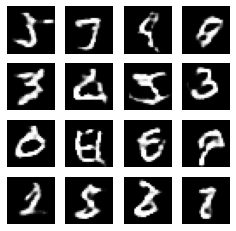

In [21]:
train(train_dataset, EPOCHS)

Populating the interactive namespace from numpy and matplotlib


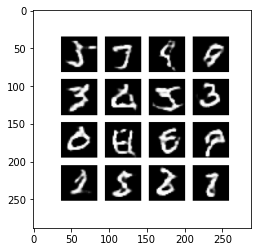

In [24]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/image_at_epoch_0025.png')
imgplot = plt.imshow(img)
plt.show()

* I have used the batch size of 100 to get better performance. Reducing the batch size will further improve the performance however, requires extra time to execute.
* I have run the model only for 25 epochs considering the compute power available and got the above results. It can be furhter improved increasing the number of epochs.